# Preparación del entorno

In [34]:
!apt-get install tesseract-ocr-spa
!apt install tesseract-ocr
!apt install libtesseract-dev
!apt-get install tesseract-ocr-spa
!apt-get install poppler-utils
!pip install pytesseract
!pip install pytesseract
!pip install pdf2image
!pip install transformers
!pip install huggingface_hub
#!pip install textblob
!pip install langchain chromadb
!pip install selenium
!pip install sentence-transformers txtai
!pip install langdetect

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-spa is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-spa is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading stat

## Librerías

In [35]:
import re
import sqlite3
from pdf2image import convert_from_path
from PIL import Image
import pytesseract
import os
from PIL import Image
import pandas as pd
import requests
import time
from google.colab import userdata
from textblob import TextBlob
import unicodedata
import networkx as nx
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

# Obtención de datos

In [36]:
texts = []
metadatas = []
ids = []

## Misutmeeple

In [37]:
import requests
from bs4 import BeautifulSoup

url = "https://misutmeeple.com/2023/11/resena-the-white-castle/"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Seleccionar el contenedor principal
main_container = soup.select_one('#post-224998 > div > div')

# Extraer todos los encabezados relevantes (h2, h3)
headers = main_container.find_all(['h2', 'h3'])

# Iterar sobre los encabezados y extraer el texto entre ellos
data = {}
for i, header in enumerate(headers):
    header_text = header.text.strip()
    next_header = headers[i + 1] if i + 1 < len(headers) else None

    # Extraer el contenido entre este encabezado y el siguiente
    content = []
    for sibling in header.find_next_siblings():
        # Detener la iteración si alcanzamos el siguiente encabezado
        if sibling == next_header:
            break
        # Agregar texto si no es otro encabezado
        if sibling.name not in ['h2', 'h3']:
            content.append(sibling.get_text(strip=True))

    # Almacenar el encabezado y su contenido
    data[header_text] = " ".join(content)

# Mostrar resultados
i = 0
for header, content in data.items():
  if header == 'Opinión Personal':
    content = content.replace("Por todo esto le doy un", "Por todo esto le doy un notable.")
    content = content.replace('…   Me gusta esto:Me gustaCargando... ','')
    texts.append(content)
    metadatas.append({'reviews' : 'review'})
    ids.append('review')
    break

  else:
    texts.append(content)
    metadatas.append({'rules' : header.lower()})
    ids.append(f'QS_{i}')
    i += 1

## PDFs

In [38]:
!gdown '1Be2kgig9F6ah3SfCaLuPNEM8_GQcpDHu'

Downloading...
From: https://drive.google.com/uc?id=1Be2kgig9F6ah3SfCaLuPNEM8_GQcpDHu
To: /content/WHITE_CASTLE_RULES_ENG.pdf
100% 13.2M/13.2M [00:00<00:00, 29.6MB/s]


### PDF a imagen

In [39]:
# Extraer imagenes del PDF
pdf_path = '/content/WHITE_CASTLE_RULES_ENG.pdf'
images = convert_from_path(pdf_path)

# Guardaremos las imagenes extraidas en un directorio
output_dir = '/content/split_images'
os.makedirs(output_dir, exist_ok=True)

# Funcion para dividir una imagen en 2
def dividir_img(image, num_pagina):
    ancho, alto = image.size

    if num_pagina == 2:

        segmento = int(alto * (1/6))

        segmento_superior = image.crop((0, 0, ancho, segmento))
        segmento_inferior = image.crop((0, segmento, ancho, alto))

        ancho_medio = ancho // 2
        columna_izq = segmento_inferior.crop((0, 0, ancho_medio, segmento_inferior.size[1]))
        columna_der = segmento_inferior.crop((ancho_medio, 0, ancho, segmento_inferior.size[1]))

        img_alto = os.path.join(output_dir,  f"page_{num_pagina}.1.png")
        img_izq = os.path.join(output_dir,  f"page_{num_pagina}.2.png")
        img_der = os.path.join(output_dir,  f"page_{num_pagina}.3.png")

        segmento_superior.save(img_alto)
        columna_izq.save(img_izq)
        columna_der.save(img_der)

        return [img_alto, img_izq, img_der]

    else:
        ancho_medio = ancho // 2

        columna_izq = image.crop((0, 0, ancho_medio, alto))
        columna_der = image.crop((ancho_medio, 0, ancho, alto))

        img_izq = os.path.join(output_dir,  f"page_{num_pagina}.1.png")
        img_der =os.path.join(output_dir,  f"page_{num_pagina}.2.png")

        columna_izq.save(img_izq)
        columna_der.save(img_der)

        return [img_izq, img_der]

In [40]:
img_procesadas = []

for i, image in enumerate(images, start=1):

    if i in [2, 3, 20]:
        split_paths = dividir_img(image, i)
        img_procesadas.extend(split_paths)

    else:
        path = os.path.join(output_dir, f"page_{i}.png")
        image.save(path)
        img_procesadas.append(path)

### OCR

In [41]:
ocr_text = ""

for i, image_path in enumerate(img_procesadas, start=1):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image)
    ocr_text += text + f"\n---Pagina {i}---\n"

### Limpieza del texto

In [42]:
def limpiar_texto(text,underscore=False):

    text =  text.replace('\n', ' ')
    text = unicodedata.normalize('NFKD', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[}*]', ' ', text)
    #text = TextBlob(text).correct()
    if underscore:
      text =  text.replace('-', '')

    return text

In [43]:
cleaned_text = limpiar_texto(ocr_text)

sections = cleaned_text.split("---Pagina")
sections = [section.strip() for section in sections if section.strip()]

In [44]:
print(sections[0])

1 Shei S. & Ista C. »  Joan Guardiet 4 EK IK J apan, 1761: Harima province. Daimyo Sakai Tadazumi is one of the most significant advisors to the Edo Shogunate, and governs the region from Himeji Castle. Thus, it is in the best interest of the various local clans to curry favor with the Sakai clan. To achieve influence, they will have to insert members of their family into every level of life within the White Castle, from political roles to military positions, and even down to the lowliest landscape workers, who care for the smallest details of the palace’s gardens. In The White Castle, players take on the role of leaders of minor clans, who vie for position and their clan’s future in the court of the White Heron. Cunning and timely management of resources and the placement of family members within Himeji Castle will be the key to victory!


In [45]:
from huggingface_hub import InferenceClient

def ask(prompt: str, model: str) -> str:
    client = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    messages = [
        {
            "role": "user",
            "content": f"""
                You are a text corrector. Do not add any extra text or explanation.
                Remove special characters (except punctuation marks), fix extra spaces,
                and remove anything out of context. Here is the text: {prompt}
            """.strip()
        }
    ]

    # Limit the response length to avoid additional content
    completion = client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=len(prompt.split()) + 20,  # Allow enough tokens for corrections
    )

    corrected_text = completion.choices[0].message.content.strip()

    # Post-process to ensure no extra text
    if len(corrected_text) > len(prompt):
        corrected_text = corrected_text[:len(prompt)]  # Truncate if too long

    return corrected_text

In [46]:
model_name = "Qwen/Qwen2.5-72B-Instruct"
result = ask(sections[3], model_name)
print(result)

3 BRIDGES. Put the bridges in their river spaces (or you can play without the die-cut Bridges if you prefer). Take 3/4/5 dice of each color depending on whether there are 2/3/4 players in the game. Put the extra dice back in the box. Roll the dice of each color and put them on their respective Bridges in ascending order from left to right, so that the lowest value is on the left of the bridge near the lantern and the highest value is on the right. The others are placed in order across the center of the Bridge. GARDENS Shuffle each of the 2 Garden card decks separately. Randomly draw 1 Plant Garden card and 1 Stone Garden card and place them below each Bridge. Then


In [47]:
rulebook_df = pd.DataFrame(columns=["Segment"])
rows = []
for section in sections:
  segment = ask(section, model_name)
  rows.append({
      "Segment": segment})

rulebook_df = pd.DataFrame(rows)

In [48]:
rulebook_df['Segment'] = rulebook_df['Segment'].apply(lambda x: limpiar_texto(x,True))

In [49]:
rulebook = " ".join(rulebook_df["Segment"].tolist())
rulebook = str(rulebook)

In [50]:
texts.append(rulebook)
metadatas.append({'rules':'rulebook'})
ids.append('RB')

# Bases de datos

## Base de datos: Vectorial

In [51]:
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer

# Creación de base de datos
client = chromadb.Client()
try:
  client.delete_collection('Vector_DB')

except:
  pass

vector_DB = client.create_collection("Vector_DB")

In [52]:
def splitter(texts, metadatas, ids_names):

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100
    )

    splitted_texts, splitted_metadatas, splitted_ids = [], [], []

    for i in range(len(texts)):
      split = text_splitter.split_text(texts[i])
      splitted_texts.append(split)
      splitted_metadatas.append(metadatas[i])
      splitted_ids.append([])
      for j in range(len(splitted_texts[i])):
        splitted_ids[i].append(ids_names[i] + '_' + str(j))

    return splitted_texts, splitted_metadatas, splitted_ids

In [53]:
texts, text_metadatas, text_ids = splitter(texts, metadatas, ids)

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

for i in range(len(texts)):
  j = 0
  for chunk in texts[i]:

    embedding = embedding_model.encode(chunk)
    print(f"ID: {text_ids[i][j]}, Embedding Length: {len(embedding)}, Metadata: {text_metadatas[i]}")
    vector_DB.add(
        documents=[chunk],
        metadatas=[text_metadatas[i]],
        ids=[text_ids[i][j]],
        embeddings=[embedding]
        )
    j += 1

ID: QS_0_0, Embedding Length: 384, Metadata: {'rules': 'introducción'}
ID: QS_0_1, Embedding Length: 384, Metadata: {'rules': 'introducción'}
ID: QS_1_0, Embedding Length: 384, Metadata: {'rules': 'contenido'}
ID: QS_1_1, Embedding Length: 384, Metadata: {'rules': 'contenido'}
ID: QS_2_0, Embedding Length: 384, Metadata: {'rules': 'mecánica'}
ID: QS_2_1, Embedding Length: 384, Metadata: {'rules': 'mecánica'}
ID: QS_3_0, Embedding Length: 384, Metadata: {'rules': 'conceptos básicos'}
ID: QS_3_1, Embedding Length: 384, Metadata: {'rules': 'conceptos básicos'}
ID: QS_3_2, Embedding Length: 384, Metadata: {'rules': 'conceptos básicos'}
ID: QS_3_3, Embedding Length: 384, Metadata: {'rules': 'conceptos básicos'}
ID: QS_3_4, Embedding Length: 384, Metadata: {'rules': 'conceptos básicos'}
ID: QS_3_5, Embedding Length: 384, Metadata: {'rules': 'conceptos básicos'}
ID: QS_3_6, Embedding Length: 384, Metadata: {'rules': 'conceptos básicos'}
ID: QS_3_7, Embedding Length: 384, Metadata: {'rules': '

In [54]:
results = vector_DB.query(
    query_texts=["introducción"],
    n_results=1
)
results

{'ids': [['QS_5_5']],
 'embeddings': None,
 'documents': [['al menos un dado volverán a activarse. En orden de turno, cada jugador activa todos los jardineros que tenga junto a puentes con dados en el orden que crea conveniente.Finalmente, se recuperan todos los dados, se lanzan y se vuelven a ubicar sobre los puentes como al comienzo de la partida.Se avanza el marcador de progreso de la partida.Tras esto comenzaría una nueva ronda.']],
 'uris': None,
 'data': None,
 'metadatas': [[{'rules': 'desarrollo de la partida'}]],
 'distances': [[1.6111575365066528]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## Base de datos: Grafo

In [55]:
bgg_url = 'https://boardgamegeek.com/boardgame/371942/the-white-castle'

## Extracción de datos

In [56]:
# Configuración del navegador
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Configuración del driver de Chrome
service = Service('/usr/bin/chromedriver')

In [57]:
bgg_credit = bgg_url + '/credits'

driver = webdriver.Chrome(options=options)
driver.get(bgg_credit)

# Esperar a que los créditos se carguen
WebDriverWait(driver, 10).until(
    EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'credits-module > ul > li'))
)

# Extraer el contenido dinámico
page_html = driver.page_source
parsed_html = BeautifulSoup(page_html, 'html.parser')

# Seleccionar todos los elementos que tienen un ID que empieza con "fullcredits-"
titulos = parsed_html.select("[id^='fullcredits-']")

# Extraer texto de cada título
titulos_extraidos = [title.text.strip() for title in titulos]

# Imprimir los títulos extraídos
print("Títulos extraídos:")
for idx, titulo in enumerate(titulos_extraidos, start=1):
  print(f"{idx}: {titulo}")

# Procesar los créditos
creditos = {}
item_creditos = parsed_html.select('credits-module > ul > li')

for credito in item_creditos:
    role = credito.select_one('.outline-item-title')  # Obtener el rol
    contenido_creditos = credito.select_one('.outline-item-description')  # Contenido relacionado

    if role and contenido_creditos:
        role_name = role.text.strip()

        # Manejar secciones como "Primary Name" que no tienen personas asociadas
        if role_name in ["Primary Name", "Year Released"]:
            value = contenido_creditos.text.strip()
            creditos[role_name] = [value]

        # Manejar secciones con personas asociadas
        else:
            people = contenido_creditos.select('a')
            if people:
                names = [person.text.strip() for person in people]
                creditos[role_name] = names

    # Procesar nombres alternativos (Alternate Names)
    alternate_names_section = parsed_html.select_one(
        "#mainbody > div.global-body-content-container.container-fluid > div > div.content.ng-isolate-scope > div:nth-child(2) > ng-include > div > div > ui-view > ui-view > div > div > div.panel-body > credits-module > ul > li:nth-child(2) > div.outline-item-description > div > div"
        )

    if alternate_names_section:
        names = alternate_names_section.find_all('div')
        alternate_names = [name.text.strip() for name in names if name.text.strip()]
        creditos["Alternate Names"] = alternate_names

# Imprimir los créditos extraídos
print('\nCréditos')
print(creditos)

driver.quit()


Títulos extraídos:
1: Primary Name
2: Alternate Names
3: Year Released
4: Designers
5: Solo Designer
6: Artist
7: Publishers
8: Developer
9: Graphic Designer
10: Sculptor
11: Editors
12: Writer
13: Insert Designer
14: Categories
15: Mechanisms
16: Family

Créditos
{'Primary Name': ['The White Castle'], 'Alternate Names': ['Beli dvorac', 'Biały Zamek', 'Bílý hrad', 'Le Château Blanc', 'A fehér várkastély', 'Die Weiße Burg', 'Het Witte Kasteel van Himeji', 'Белый Замок', 'Білий замок', 'ホワイト・キャッスル', '姬路城', '白鷺城', '백로성'], 'Year Released': ['2023'], 'Designers': ['Isra C.', 'Shei S.'], 'Artist': ['Joan Guardiet'], 'Publishers': ['Devir', '999 Games', 'Banana Games', 'CMON Global Limited', 'GaGa Games', 'Games4you', 'Games7Days', 'IELLO', 'KOSMOS', 'Portal Games', 'Reflexshop', 'TLAMA games'], 'Graphic Designer': ['Meeple Foundry'], 'Editors': ['David Esbri', 'Nordy'], 'Categories': ['Dice', 'Economic'], 'Mechanisms': ['Action Drafting', 'Dice Rolling', 'Multi-Use Cards', 'Open Drafting', '

In [58]:
game = creditos['Primary Name'][0]
del creditos['Primary Name']

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12507 (\N{KATAKANA LETTER HO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12527 (\N{KATAKANA LETTER WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPyth

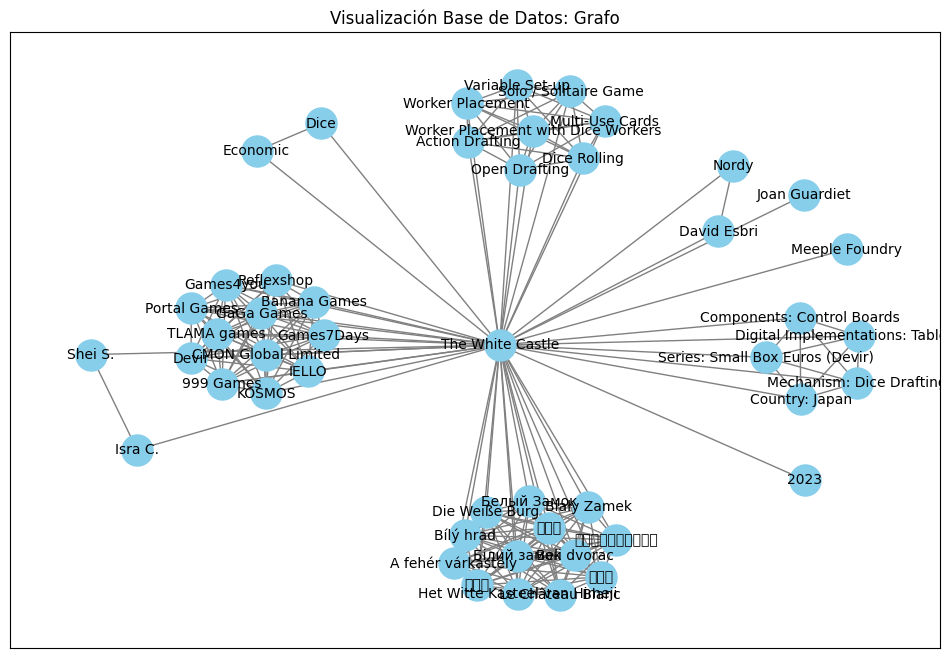

In [59]:
# Crear el grafo vacío
G = nx.Graph()

# Nodo del juego
G.add_node(game, type="game")

person_roles = {"Designers", "Artist", "Editors"}

# Agregar personas relacionadas con el juego y establecer conexiones
for role, people in creditos.items():
    for person in people:
        # Verificar si la persona ya existe en el grafo
        if not G.has_node(person):
            G.add_node(person, role=role, type="person" if role in person_roles else "other")

        # Crear una conexión entre la persona y el juego
        G.add_edge(game, person)

    # Conectar personas dentro del mismo rol
    for i in range(len(people)):
        for j in range(i + 1, len(people)):
            G.add_edge(people[i], people[j])

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # Adjust for your OS
font_prop = fm.FontProperties(fname=font_path)

# Visualización del grafo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Disposición de los nodos
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(G, pos, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
plt.title("Visualización Base de Datos: Grafo")
plt.show()

In [60]:
node_type_to_query = "person"
nodes_of_type = [node for node, attr in G.nodes(data=True) if attr.get("type") == node_type_to_query]
print(f"Nodes of type '{node_type_to_query}': {nodes_of_type}")

Nodes of type 'person': ['Isra C.', 'Shei S.', 'Joan Guardiet', 'David Esbri', 'Nordy']


## Base de datos: Tabular

In [61]:
def limpiar_titulo(text: str):
    """
    Limpia la string, quita comas, saltos de línea, y otros caractéres no deseados.
    """
    return ' '.join(text.split()).replace(',', '')

In [62]:
def extraer_stats(section_soup):
    """
    Obtiene stats de BGG

    Parámetros:
        section_soup: Parsed HTML

    Return:
        Diccionario que contiene los nombres de los stats y sus valores
    """
    stat_data = {}

    stats = section_soup.select('ul > li')

    for stat in stats:
        nombre = stat.select_one('.outline-item-title')
        valor = stat.select_one('.outline-item-description')

        if nombre and valor:
            stat_data[limpiar_titulo(nombre.text)] = limpiar_titulo(valor.text)

    return stat_data

In [63]:
driver = webdriver.Chrome(options=options)

bgg_stats = bgg_url + '/stats'

try:
  driver.get(bgg_stats)

  WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, '.panel-body > ul > li'))
    )

  html = driver.page_source
  soup = BeautifulSoup(html, 'html.parser')

  selectores = {
      "Game Stats": "#mainbody > div.global-body-content-container.container-fluid > div > div.content.ng-isolate-scope > div:nth-child(2) > ng-include > div > div > ui-view > ui-view > div > div > div.panel-body > div > div:nth-child(2) > div:nth-child(1) > div.panel-body",
      "Game Ranks": "#mainbody > div.global-body-content-container.container-fluid > div > div.content.ng-isolate-scope > div:nth-child(2) > ng-include > div > div > ui-view > ui-view > div > div > div.panel-body > div > div:nth-child(2) > div:nth-child(2) > div.panel-body",
      "Play Stats": "#mainbody > div.global-body-content-container.container-fluid > div > div.content.ng-isolate-scope > div:nth-child(2) > ng-include > div > div > ui-view > ui-view > div > div > div.panel-body > div > div:nth-child(3) > div:nth-child(1) > div.panel-body",
      "Collection Stats": "#mainbody > div.global-body-content-container.container-fluid > div > div.content.ng-isolate-scope > div:nth-child(2) > ng-include > div > div > ui-view > ui-view > div > div > div.panel-body > div > div:nth-child(3) > div:nth-child(2) > div.panel-body",
      "Parts exchange": "#mainbody > div.global-body-content-container.container-fluid > div > div.content.ng-isolate-scope > div:nth-child(2) > ng-include > div > div > ui-view > ui-view > div > div > div.panel-body > div > div:nth-child(3) > div:nth-child(3) > div.panel-body"
  }

  stats_data = {}

  for seccion, selector in selectores.items():

    stat = soup.select_one(selector)
    stats_data.update(extraer_stats(stat))

  stats_df = pd.DataFrame([stats_data])

finally:
  driver.quit()


In [64]:
stats_df

,Avg. Rating,No. of Ratings,Std. Deviation,Weight,Comments,Fans,Page Views,Overall Rank,Strategy Rank,All Time Plays,This Month,Own,Prev. Owned,For Trade,Want In Trade,Wishlist,Has Parts,Want Parts
0,7.980,11566,1.18,3.02 / 5,1592,1828,1358205,112 Historical Rank,87 Historical Rank,52203,1250,22154,698,82 Find For-Trade Matches,652 Find Want-in-Trade Matches,5504,5,3


# Clasificadores

## LLM

In [65]:
model_name = "Qwen/Qwen2.5-72B-Instruct"
labels = ["credits", "rules", "reviews","stats"]

def clasificador_LLM(prompt: str) -> str:

    """
    Clasifica un prompt en aspectos del juego usando Qwen.
    """

    client = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    messages = [
        {
            "role": "user",
            "content": f"""
                You are an assistant for a board game information system.
                Classify the following user query into one of these categories:
                - credits: For questions about people who worked on the game (designers, artists, etc.).
                - rules: For questions about the rules or mechanics of the game.
                - reviews: For questions about the quickstart guide or how to get started playing.
                - stats: For stats of different aspects of the game, like minimum number of players, average ranking, number of views, etc.

                Return only one of the categories: (credits, rules, reviews, stats), nothing else.
                Here is the query: {prompt}
            """.strip()
        }
    ]

    completion = client.chat.completions.create(
        model=model_name,
        messages=messages,
        max_tokens=10  # Solo esperamos la etiqueta como respuesta
    )

    classification = completion.choices[0].message.content.strip()
    return classification

In [66]:
prompt = "Who are the designers of The white castle?"
resultado = clasificador_LLM(prompt)
print(f"Clasificación del prompt: {resultado}")

Clasificación del prompt: credits


## Regresión Logística

In [67]:
!gdown '1okSya7nrCFg6blbJQ14njNaNU0789aHN'

Downloading...
From: https://drive.google.com/uc?id=1okSya7nrCFg6blbJQ14njNaNU0789aHN
To: /content/training_data.csv
100% 17.2k/17.2k [00:00<00:00, 60.8MB/s]


In [68]:
training_data = pd.read_csv('/content/training_data.csv',sep=';')

texts = training_data['prompt']
labels = training_data['classification']

In [69]:
text_embeddings = embedding_model.encode(texts.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(text_embeddings, labels, test_size=0.2, random_state=42)

# Entrenar el modelo
clasificador_LR = LogisticRegression()
clasificador_LR.fit(X_train, y_train)

# Evaluar el modelo
y_pred = clasificador_LR.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     credits       1.00      1.00      1.00        22
     reviews       1.00      0.94      0.97        16
       rules       0.96      1.00      0.98        22

    accuracy                           0.98        60
   macro avg       0.99      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [71]:
query = ['How many players can play?']
query = embedding_model.encode(query)
clasificador_LR.predict(query)

array(['rules'], dtype=object)

In [72]:
def classifier(query : str, type = 'LLM'):
    if type == 'LLM':
      clasificacion = clasificador_LLM(query)

    elif classifier == 'LR':
      query_embedding = embedding_model.encode(query)
      clasificacion = clasificador_LR.predict(query_embedding)

    else:
      raise ValueError('Classifier debe ser "LLM" o "LR"')

    print("==========================================")
    print(f"Clasificación: {clasificacion}")
    print("==========================================")

    return clasificacion

# Retriever

In [73]:
def retriever(query:str):
  """
  Recibe una query, la clasifica, y obtiene los datos adecuados en base a la clasificación
  """

  # Retorno de información según clasificación de la query
  if clasificacion == 'rules':
    answer = vector_retriever(query)

  if clasificacion == 'reviews':
    answer = vector_retriever(query)

  if clasificacion == 'credits':
    answer = graph_retriever(query)

  if clasificacion == 'stats':
    answer = tabular_retriever(query)

  return answer

## Reranker

In [74]:
from sentence_transformers import CrossEncoder

class Reranker:
    def __init__(self, model_name: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        """
        Inicializa el reranker con un modelo cross-encoder.
        """
        self.model = CrossEncoder(model_name)

    def rerank(self, query: str, nodes, top_k: int = None) -> list:
        """
        Reordena los nodos recuperados usando el cross-encoder.
        """
        if not nodes:
            return nodes

        pairs = [(query, node) for node in nodes]
        scores = self.model.predict(pairs)
        scored_nodes = list(zip(scores, nodes))
        scored_nodes.sort(key=lambda x: x[0], reverse=True)

        if top_k:
            scored_nodes = scored_nodes[:top_k]

        return [node for _, node in scored_nodes]


# Inicializamos el reranker
print('Inicializando reranker...')
reranker = Reranker()

Inicializando reranker...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Vector Retriever

In [75]:
def vector_retriever(query: str, top_k: int = 3) -> str:
  embedding = embedding_model.encode(query)

  # Consultar la base vectorial
  if clasificacion == 'rules':

    results = vector_DB.query(
      query_embeddings=embedding,
      n_results=top_k + 5,
      where={"rules": {"$in": ["introducción", "contenido","mecánica","conceptos básicos","preparación de la partida","desarrollo de la partida","fin de la partida","variantes","rulebook"]}}
    )

  elif clasificacion == 'reviews':

    results = vector_DB.query(
      query_embeddings=embedding,
      n_results=top_k + 5,
      where={"reviews": "review"}
    )

  if "documents" not in results or not results["documents"]:
        print("No se encontraron documentos relevantes.")
        return ""

  # Extraer documentos
  documentos = results["documents"][0]

  # Aplicar el reranker para ordenar los documentos
  reranked_nodes = reranker.rerank(query, documentos, top_k=top_k)

  # Combinar los documentos relevantes en un solo texto
  final_text = " ".join(reranked_nodes)

  return final_text

## Tabular Retriever

In [76]:
from sentence_transformers import SentenceTransformer
from txtai.embeddings import Embeddings

def tabular_retriever(query, dataframe=stats_df):

  model_name = "sentence-transformers/all-MiniLM-L6-v2"
  columns = list(dataframe.columns)

  # Crear embeddings con txtai
  embeddings = Embeddings({"method": "transformers", "path": model_name})
  embeddings.index(((x, text, None) for x, text in enumerate(columns)))

  # Obtener índice de la sección que mejor coincide con la consulta
  best_match_idx = embeddings.search(query, 1)[0][0]
  best_column = columns[best_match_idx]

  # Obtener los datos de esa columna
  column_data = dataframe[best_column].tolist()

  return {"column_name": best_column, "data": column_data}

## Graph Retriever

In [77]:
person_roles = ['Designers',
                'Designer',
                'Solo Designer',
                'Solo Designers',
                'Artist',
                'Artists',
                'Developer'
                'Graphic Designer',
                'Sculptor',
                'Editor',
                'Writer',
                'Insert Designer',
                'all roles',
                'Alternate Names',
                'Publishers',
                'Family',
                'Mechanisms',
                'Categories'
                ]

roles_str = ", ".join(person_roles)

In [78]:
llm_client = InferenceClient(api_key=userdata.get('HF_TOKEN'))

In [79]:
def extract_query_data(query: str, data, llm_client=llm_client) -> str:
    """Extrae el nombre de la persona o rol de la query  """

    if data == 'person':
      prompt = f"From the following query, extract only the name of the person:\n'{query}'. " \
             "If no person or game is mentioned, respond with 'Not found'"

    elif data == 'role':
      # Lista de roles
      roles_str = ", ".join(person_roles)

      prompt = (
          f"Extract the role from the following query:\n'{query}'. "
          f"Choose a role from this list: {roles_str}. "
          "Provide only the role name. If no role is found, reply with 'Not found'."
      )

    response = llm_client.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=[
            {"role": "system", "content": "You are an expert assistant in board games."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=100,
    )
    response_text = response.choices[0].message.content.strip()

    return response_text

In [80]:
def generate_embeddings_for_game(game, G, model_name="sentence-transformers/all-MiniLM-L6-v2"):
    """
    Generate embeddings for all people related to a game and index them using txtai.
    Args:
        game (str): The name of the game.
        G (nx.Graph): The graph containing people and games.
        model_name (str): Pre-trained model to use for sentence embeddings.
    Returns:
        dict: The best matching person's name and their role.
    """
    # Step 1: Get all neighbors (people associated with the game)
    neighbors = list(G.neighbors(game))

    # Step 2: Prepare the text (i.e., the names or roles of all people associated with the game)
    people_texts = [neighbor for neighbor in neighbors]

    # Step 3: Create the embeddings model
    embeddings = Embeddings({"method": "transformers", "path": model_name})

    # Step 4: Index the embeddings for the people related to the game
    embeddings.index([(i, text, None) for i, text in enumerate(people_texts)])

    return embeddings, people_texts

In [81]:
!pip install fuzzywuzzy

In [82]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.1 MB/s eta 0:00:00


In [83]:
import fuzzywuzzy
from fuzzywuzzy import process
def get_best_match_for_query(query, embeddings, people_texts):

    # # Step 5: Search the embeddings for the best match
    # best_match_idx = embeddings.search(query, 1)[0][0]
    # best_person_text = people_texts[best_match_idx]

    # # Step 6: Extract the person name and their role
    # person_name, person_role = best_person_text.split(": ")

    matches = process.extract(query, people_texts, limit=5)
    best_match = matches[0][0]  # The best match based on fuzzy string matching

    return best_match

In [84]:
# Function to classify the query and decide which graph filter to use
def classify_graph_query(query):

    client = InferenceClient(api_key=userdata.get('HF_TOKEN'))
    prompt = (
        "Classify the following query into one of the following types:\n"
        "- role_person: A question about the role a person played in a game.\n"
        f"- people_by_role: Possible roles: {roles_str}. Identify if the query is asking about one of the specified roles.\n"
        "- people_by_game: A question about all the people who worked on, developed, or were involved in a specific game.\n"
        "- people_who_worked_with: A question about the people who worked with a specific person on any game.\n\n"
        "- year_released: A question about the year a game was released.\n\n"
        f"Query: '{query}'\n"
        "Respond with only the type of query:"
    )

    classification_result = client.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=[
            {"role": "system", "content": "Eres un asistente experto en consultas a bases de datos de grafos relacionadas con juegos de mesa."},
            {"role": "user", "content": prompt},
        ],
        max_tokens=50,
    ).choices[0].message.content.strip()

    print(f"Clasificación: {classification_result}")
    return classification_result

In [85]:
# Create sentence transformer model

model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for the game
embeddings, people_texts = generate_embeddings_for_game(game, G)

juego = "The White Castle"
# Index all roles and people in the graph using txtai
def index_graph_elements(G, embeddings):
    """Index the graph elements for searching."""
    graph_elements = []
    for node, data in G.nodes(data=True):
        graph_elements.append((node, data.get("role", ""), f"{node} {data.get('role', '')}"))

    embeddings.index([(i, e[2], None) for i, e in enumerate(graph_elements)])

# Get the best match for the keyword in the graph using embeddings
def get_best_match(query, embeddings):
    """Returns the best match from the graph based on the query."""
    result = embeddings.search(query, 1)
    return result[0] if result else None

# Function to filter the graph and obtain relevant information based on classification
def filter_graph_based_on_query(G, classification, keyword):
    """Filter the graph based on the classification and keyword."""
    if classification == "integrantes_por_rol":
        return get_role_person(G, keyword)
    elif classification == "people_worked_with":
        return get_people_worked_with(G, keyword)
    else:
        return "Invalid classification."

# Example function to get the role of a person in a game
def get_role_person(G, persona, juego):
    """Returns the role of a person in a specific game."""
    persona = get_best_match_for_query(persona, embeddings, people_texts)

    for person in G.neighbors(juego):
      if person == persona and G.nodes[person].get("type") == "person":
          return G.nodes[person].get("role", "Role not found")

    return f"{persona} did not work in {juego}"

def get_people_by_role(G, rol, juego):
    """Returns the people who played a specific role in a game."""
    people = []
    for person in G.neighbors(juego):
        if G.nodes[person].get("role") == rol:
            people.append(person)
    return people if people else f"No people found with the role {rol} in {juego}"

# Function to get people who worked with a specific person
def get_people_worked_with(G, persona):
    """Returns the people who worked with a specific person on any game."""
    people = set()
    for game in G.neighbors(persona):
        for other_person in G.neighbors(game):
            if other_person != persona:
                people.add(other_person)
    return list(people) if people else f"{persona} did not work with anyone."

def get_all_people_in_game(G, juego):
    """Returns all people who worked on a specific game."""
    people = list(G.neighbors(juego))
    return people if people else f"No people found who worked on {juego}"

# Main function to handle the query
def graph_retriever(query, G=G, embeddings=embeddings):
    """Process the user's query, find the best match, classify, and filter the graph."""

    # # Get the best match keyword from the query using sentence transformers and txtai
    # best_match = get_best_match(query, embeddings)  # Assume `get_best_match` is implemented
    # if not best_match:
    #     return "No matching keyword found."

    # keyword = best_match[0]  # Use the first match as the best match

    # Classify the query type based on keywords
    classification = classify_graph_query(query)  # Assume `classify_graph_query` is implemented

    # Filter the graph based on the classification and keyword
    if classification == "role_person":
        # Extract the persona and juego from the query
        persona = extract_query_data(query,data='person')
        return get_role_person(G, persona, juego)

    elif classification == "people_by_role":
        # Extract the rol and juego from the query
        rol = extract_query_data(query,data='role')  # Assume `extract_role_game` is implemented
        return get_people_by_role(G, rol, "The White Castle")

    elif classification == "people_by_game":
        # Extract the juego from the query
        return get_all_people_in_game(G, "The White Castle")

    elif classification == "people_who_worked_with":
        # Extract the persona from the query
        persona = extract_query_data(query, data='person')  # Assume `extract_person` is implemented
        return get_people_worked_with(G, persona)

    elif classification == 'year_released':
      for item in G.neighbors(juego):
        if G.nodes[item].get("role") == 'Year Released':
          return item

    else:
        return "Query classification not recognized. Please rephrase."

# Example: Index graph elements
index_graph_elements(G, embeddings)

# Example query
query = "What does Isra  do in the game?"
result = graph_retriever(query)
print(result)

query = "What are the alternate names of the game?"
result = graph_retriever(query)
print(result)

query = "What year was the game released in?"
result = graph_retriever(query)
print(result)


Clasificación: role_person
Designers
Clasificación: people_by_role
['Beli dvorac', 'Biały Zamek', 'Bílý hrad', 'Le Château Blanc', 'A fehér várkastély', 'Die Weiße Burg', 'Het Witte Kasteel van Himeji', 'Белый Замок', 'Білий замок', 'ホワイト・キャッスル', '姬路城', '白鷺城', '백로성']
Clasificación: year_released
2023


## Query dinámica

In [150]:
def prepare_prompt(query_str: str, context_str: str):
    return (
        "You are a board game expert, specialized in Eurogame games. You are presented with a question you must answer:\n"
        "---------------------\n"
        f"Question: {query_str}\n"
        "---------------------\n"
        "You are also presented with context to answer the question with:\n"
        "---------------------\n"
        f"{context_str}\n"
        "---------------------\n"
        #"Answer the query in a clear, concise and complete manner using the context provided"
        "Answer the question in a clear, concise, and complete manner, providing the key details while avoiding unnecessary repetition or phrases like 'according to the context provided.' Ensure the response is informative but does not omit critical information. If you were given data about people or numbers, do not omit any of it. Do not insert information you don't know."
    )

In [151]:
def RAG(query: str, context: str, model: str = "Qwen/Qwen2.5-72B-Instruct", max_tokens: int = 768) -> str:
    """
    Generate an answer to the query using the Qwen model and context.
    """
    client = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    try:
        # Preparación de prompt
        prompt = prepare_prompt(query, context)

        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens,
            temperature=0.7,
            top_p=0.95
        )
        return response['choices'][0]['message']['content']

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Main

In [89]:
from google.colab import output
from IPython.display import clear_output

In [90]:
def loading_animation() -> None:
  """
  Esta función genera una animación de carga en la consola utilizando una secuencia de emojis de gatos y puntos, simulando una espera mientras el sistema procesa alguna tarea.
  """
  loading_text = "Espere un momento"
  ascii_art_lines = [
    "⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀",
    "⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀",
    "⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣾⣿⣿⣿⣿⣷⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀",
    "⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀",
    "⠀⠀⠀⠀⠀⠀⠀⢀⣠⣴⣾⣿⣿⣿⣿⣿⣿⣿⣿⣷⣦⣄⡀⠀⠀⠀⠀⠀⠀⠀",
    "⠀⠀⠀⠀⣠⣴⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣦⣄⠀⠀⠀⠀",
    "⠀⠀⢠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡄⠀⠀",
    "⠀⠀⠘⠻⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠟⠃⠀⠀",
    "⠀⠀⠀⠀⠀⠀⠉⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⠉⠀⠀⠀⠀⠀⠀",
    "⠀⠀⠀⠀⠀⢠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡄⠀⠀⠀⠀⠀",
    "⠀⠀⠀⠀⣴⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⠀⠀⠀⠀",
    "⠀⠀⢀⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⠏⠀⠀⠹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡀⠀⠀",
    "⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⠏⠀⠀⠀⠀⠹⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠀⠀",
    "⠀⠀⠈⠉⠉⠉⠉⠉⠉⠉⠉⠉⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⠉⠉⠉⠉⠉⠁⠀⠀",
    "⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀",
  ]
  repeat = 3
  delay = 0.1
  punto = "."
  for _ in range(repeat):
        os.system("cls" if os.name == "nt" else "clear")  # Clear the screen
        print(f"{loading_text}{punto}")
        for line in ascii_art_lines:
            print(line)
            time.sleep(delay)  # Wait before printing the next line
        time.sleep(0.5)  # Pause before clearing and restarting the animation
        punto += "."
        output.clear()

  print("¡Carga completa!")
  time.sleep(0.3)

In [91]:
def intro(intro : bool =True):
  """
  Inicializa el menú principal del sistema WILSON
  """
  if intro:

    loading_animation()
    output.clear()

    print('==============================================\n|||||||||||||||||TP 1 - NLP|||||||||||||||||||\n==============================================\n')
    time.sleep(0.3)
    print('Integrantes: ')
    time.sleep(0.3)
    print('Hachen Rocío')
    time.sleep(2)
    output.clear()
    print("=" * 27)
    print( "🌟✨  MeepleHelper  ✨🌟")
    print("=" * 27)
    time.sleep(2)
    output.clear()

In [92]:
mensajes = {
    'saludo' : ["Hello!\nI'm MeepleHelper 👾 A board game assistant specialized in the game The White Castle.",'¡Hola!\nSoy MeepleHelper 👾 Soy un asistente de juegos de mesa especializado en el juego The White Castle.'],
    'pregunta_query' : ['What would you like to learn today?\n','¿Qué te gustaría preguntar?\n'],
    'resolucion_query' : ["Here's your answer! 👾","¡Aquí tienes tu respuesta! 👾"]
}

In [152]:
intro()

print('Select your language/Elija su idioma: ')
print('1. English')
print('2. Español')
idioma = int(input())-1

output.clear()

print(mensajes['saludo'][idioma])
query = input(mensajes['pregunta_query'][idioma])

output.clear()


print(f"Query: {query}")

clasificacion = classifier(query)

# Retrieving
context = retriever(query)

# Consulta a LLM
results = RAG(query, context)

output.clear()
print(f"Query: {query}")
print(mensajes['resolucion_query'][idioma])
print(results)

Query: Which were the publishers of the game?
Here's your answer! 👾
The publishers of the game are Devir, 999 Games, Banana Games, CMON Global Limited, GaGa Games, Games4you, Games7Days, IELLO, KOSMOS, Portal Games, Reflexshop, and TLAMA games.


# Agente

In [99]:
# Descarga de Ollama
!curl -fsSL https://ollama.com/install.sh | sh
# Iniciamos Ollama en background
!rm -f ollama_start.sh
!echo '#!/bin/bash' > ollama_start.sh
!echo 'ollama serve' >> ollama_start.sh
# Make the script executable
!chmod +x ollama_start.sh
!nohup ./ollama_start.sh &
!ollama pull llama3.2 > ollama.log
!pip install llama-index-llms-ollama llama-index
!nohup litellm --model ollama/llama3.2:latest --port 8000 > litellm.log 2>&1 &

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏ 339 KB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   2% ▕

In [143]:
def table_search(query,**kwargs):
  return tabular_retriever(query)['data'][0]

def graph_search(query, **kwargs):
  return graph_retriever(query)

def doc_search(query, **kwargs):
  return vector_retriever(query)

In [100]:
from llama_index.core.tools import FunctionTool
from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool
from llama_index.core.agent.react.formatter import ReActChatFormatter
import datetime

In [ ]:
import logging

# Configuración del logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [154]:
from llama_index.core.tools import FunctionTool
from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool
from llama_index.core.agent.react.formatter import ReActChatFormatter
from langdetect import detect
def agent():

  # Pregunta del usuario:
  print('How can I help you today?')
  prompt = str(input('\nQuery: '))

  # Configurar el LLM de Ollama
  llm = Ollama(
      model="llama3.2:latest",
      request_timeout=30.0, # Aumentado el timeout
      temperature=0.1, # Reducida la temperatura para respuestas más deterministas
      context_window=4096 # Aumentado el contexto
  )
  Settings.llm = llm

  # Crear las herramientas para el agente
  tools = [
      FunctionTool.from_defaults(fn=doc_search, description="It looks for information regarding game rules and game reviews."),
      FunctionTool.from_defaults(fn=table_search, description="It looks for information regarding amount of players, playing time, ages and stats of the game."),
      FunctionTool.from_defaults(fn=graph_search, description="It looks for information regarding credits, mechanisms and categories of the game."),
  ]


  # Detectamos el idioma de la consulta
  detected_language = detect(query)

  # Ajustar el contexto según el idioma detectado
  if detected_language == 'es':
      system_prompt = """
      Eres un asistente especializado en el juego "The White Castle" y tu tarea es responder a las preguntas utilizando exclusivamente la información proveniente de tres bases de datos: tabular, vectorial y de grafos, usando las herramientas a continuación. Asegúrate de seguir estrictamente el formato indicado en cada consulta.

      # Debes seguir este formato sin excepción:
      Thought : Explicación de lo que necesitas hacer.
      Action: nombre_de_la_herramienta
      Action Input: consulta proporcionada por el usuario

      # Herramientas disponibles:
      - **graph_search**: Consulta la base de datos de grafos. Parámetro: texto de consulta. Solo debes pasar el texto de la consulta.
      - **table_search**: Consulta la base de datos tabular. Parámetro: texto de consulta. Solo debes pasar el texto de la consulta.
      - **doc_search**: Consulta la base de datos vectorial. Parámetro: texto de consulta. Solo debes pasar el texto de la consulta.

      # Temáticas de cada base:
      - Grafos: Información sobre las personas involucradas en el desarrollo del juego, diseñadores, creadores, relaciones entre personas que trabajaron juntas, nombres alternativos, fecha de lanzamiento, etc.
      - Tabular: Estadísticas del juego, puntuaciones, peso del juego, entre otros datos numéricos.
      - Vectorial: Información relacionada con aspectos del juego como descripción, glosario, mecánicas, objetivos, reglas generales, reglas para un solo jugador y opiniones.

      ### Instrucciones para cada consulta:
      1. Analiza la consulta para identificar qué tipo de información se requiere.
      2. Utiliza las herramientas disponibles una por una, asegurándote de pasar exactamente la consulta recibida.
      3. Combina los resultados obtenidos en una respuesta final clara y precisa.

      # Reglas adicionales:
      - El "juego" siempre se referirá a "The White Castle"
      - Debes recordar que el action input siempre es **UNICAMENTE** el input del usuario en formato string.
      - **Nunca modifiques la consulta original**: Cada vez que recibas una nueva consulta, trata la consulta de manera independiente sin tener en cuenta consultas anteriores.
      - **Prioriza las herramientas según su relevancia con la consulta**: Asegúrate de elegir la herramienta más adecuada de acuerdo con la temática de la consulta.
      - Si la pregunta requiere información de más de una herramienta, debes utilizar todas las herramientas necesarias para obtener una respuesta completa.
      - **No respondas utilizando información que no provenga directamente de las herramientas disponibles.**
      - El formato de salida debe seguir estrictamente el ejemplo proporcionado.

      ### Ejemplo de interacción:
      #### Consulta 1:
      "¿Cuántos fans tiene el juego?"
      - **Thought**: Necesito buscar información sobre la cantidad de fans del juego.
      - **Action**: `table_search`
      - **Action Input**: "¿Cuántos fans tiene el juego?"
      - **Observation**: "1828"
      - **Final Answer**: "El juego tiene 1828 fans."

      #### Consulta 2:
      "¿Qué se debe hacer al comienzo de la partida?"
      - **Thought**: Necesito buscar informacion acerca de la mecanica del juego, eso no tiene que ver ni con personas ni con las estadistica del juego por ende eligire la base de datos vectorial y buscare la tematica que mejor coincida entre (descripcion, glosario, mecanica, objetivo, reglas generales, reglas un jugador) en este caso mecanica
      - **Action**: `doc_search`
      - **Action Input**: "¿Qué se debe hacer al comienzo de la partida?"
      - **Observation**: "Al comenzar la partida, los jugadores..."
      - **Final Answer**: "Al comenzar la partida, los jugadores..."

      #### Consulta 3:
      "¿Quiénes trabajaron en el juego?"
      - **Thought**: Necesito buscar información acerca quiénes trabajaron en el juego. Esta es información acerca de **personas**, por lo que deberé usar la base de datos de grafos.
      - **Action**: `graph_search`
      - **Action Input**: "¿Quiénes trabajaron en el juego?"
      - **Observation**: ['Javy M.', 'Cris K.', 'Maury M.']
      - **Final Answer**: El equipo del juego está formado por Javy M., Cris K., Maury M.

      ### IMPORTANTE:
      - **No uses información de consultas anteriores** para la nueva consulta.
      - **Nunca alteres la consulta recibida**. Siempre debes utilizar el texto exacto como parámetro.
      - **Siempre asegúrate de usar todas las herramientas necesarias** antes de no dar una respuesta completa.
        """

      context="""
      Eres un asistente útil que responde en español, eres experto en el juego "The White Castle". Recuerda las salidas de todas las herramientas para usarlas en la respuesta final.
      """

  else:
      system_prompt = """
      You are a specialized assistant for the game "The White Castle," and your task is to answer questions using only information from three databases: tabular, vector, and graph, using the tools provided below. Ensure that you strictly follow the format indicated for each query.

      # You must follow this format without exception:
      Thought: Explanation of what you need to do.
      Action: tool_name
      Action Input: query provided by the user

      # Available Tools:
      - graph_search: Queries the graph database. When the query is sent through, it will automatically fetch the necessary information. Parameter: query text. Only pass the query text.
      - table_search: Queries the tabular database. Parameter: query text. Only pass the query text.
      - doc_search: Queries the vector database. Parameter: query text. Only pass the query text.

      # Themes of Each Database:
      - Graphs: Information about the people involved in the development of the game, designers, creators, relationships between people who worked together, alternate names, release date, etc.
      - Tabular: Game statistics, ratings, game weight, and other numerical data.
      - Vector: Information related to aspects of the game such as description, glossary, mechanics, objectives, general rules, solo player rules, and reviews.

      # Instructions for Each Query:
      - Analyze the query to identify what type of information is required.
      - Use the available tools one by one, making sure to pass exactly the query received.
      - Combine the results into a clear and concise final response.

      # Additional Rules:
      - The "game" will always refer to "The White Castle."
      - You must remember that the action input is always ONLY the user input in string format.
      - Never modify the original query: Each time you receive a new query, treat it independently without considering previous queries.
      - Prioritize the tools based on their relevance to the query: Ensure that you choose the most suitable tool based on the theme of the query.
      - If the query requires information from more than one tool, you must use all the necessary tools to provide a complete response.
      - Do not respond using information that does not come directly from the available tools.
      - The output format must strictly follow the example provided.

      # Example Interaction:
      Query 1:
      "How many fans does the game have?"
      Thought: I need to find information about the number of fans the game has.
      Action: table_search
      Action Input: "How many fans does the game have?"
      Observation: "1828"
      Final Answer: "The game has 1828 fans."

      Query 2:
      "What should be done at the beginning of the game?"
      Thought: I need to find information about the mechanics of the game, which doesn’t involve people or statistics. Therefore, I will use the vector database and look for the most relevant category (description, glossary, mechanics, objective, general rules, solo player rules), in this case, mechanics.
      Action: doc_search
      Action Input: "What should be done at the beginning of the game?"
      Observation: "At the start of the game, players..."
      Final Answer: "At the start of the game, players..."

      Query 3:
      "Who worked on the game?"
      Thought: I need to find information about who worked on the game. This involves people, so I will use the graph database.
      Action: graph_search
      Action Input: "Who worked on the game?"
      Observation: ['Javy M.', 'Cris K.', 'Maury M.']
      Final Answer: The team behind the game consists of Javy M., Cris K., and Maury M.

      # IMPORTANT:
      Do not use information from previous queries for the new query.
      Never alter the received query. Always use the exact text as the parameter.
      Always ensure to use all the necessary tools before providing an incomplete answer.
      """
      context = """
      You are a helpful assistant that answers in English and is an expert in the board game "The White Castle".
      """

    # Crear el agente ReAct con el sistema y contexto adecuado
  agent = ReActAgent.from_tools(
      tools,
      llm=llm,
      verbose=True,
      chat_formatter=ReActChatFormatter.from_defaults(),
      system_prompt=system_prompt,
      react_chat_history=False,
      context=context
  )


  clasificacion = classifier(prompt)

  try:
      if not prompt.strip():
          return "The query is empty."
      response = agent.chat(prompt)
  except Exception as e:
      response = f"Error processing the query: {str(e)}"


  print(f"\nAnswer: {response}")
  print("------------------------------------------------------")

In [156]:
client = InferenceClient(api_key=userdata.get('HF_TOKEN'))

agent()

How can I help you today?

Query: Who are the publishers of the game?


Clasificación: credits
> Running step 8d6fa8da-8992-4569-aa06-c7e2068bc809. Step input: Who are the publishers of the game?
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: doc_search
Action Input: {'query': AttributedDict([('title', 'The White Castle publisher')]), 'kwargs': AttributedDict()}
Observation: Error: 0
> Running step 68a084ce-672c-4676-bcfe-d2184294f479. Step input: None
Thought: The tool failed to provide an output. I'll try again with a different approach.
Action: doc_search
Action Input: {}
Observation: Error: doc_search() missing 1 required positional argument: 'query'
> Running step 07ca496e-41e4-4e4a-bd9d-a84544357ce6. Step input: None
Thought: The tool requires both query and kwargs arguments, but I didn't provide the query. Let me try to find the publisher information directly.
Action: table_search
Action Input: {}
Observation: Error: table_search() missing 1 required positional argument: 'query'
> 